In [36]:
import multiprocessing

import pandas as pd
import numpy as np
import torch

import matplotlib.pyplot as plt
plt.rcParams['figure.dpi'] = 150
import seaborn as sns

from netam import framework, models

In [2]:
train_df, val_df = framework.load_shmoof_dataframes("/Users/matsen/data/shmoof_edges_11-Jan-2023_NoNode0_iqtree_K80+R_masked.csv") #, sample_count=5000)

In [3]:
kmer_length = 5
max_length = 410

train_dataset = framework.SHMoofDataset(train_df, kmer_length=kmer_length, max_length=max_length)
val_dataset = framework.SHMoofDataset(val_df, kmer_length=kmer_length, max_length=max_length)

print(f"we have {len(train_dataset)} training examples and {len(val_dataset)} validation examples")

we have 35830 training examples and 13186 validation examples


In [6]:
class SiteRatePenalizedSHMoofModel(models.SHMoofModel):
    def __init__(self, *args, penalty_weight, **kwargs):
        super().__init__(*args, **kwargs)
        self.penalty_weight = penalty_weight

    def regularization_loss(self):
        # Calculate L2 norm (squared sum) of the log_site_rates_long_residual weights
        reg_loss = torch.sum(self.log_site_rates.weight ** 2)
        # Apply the regularization weight
        reg_loss *= self.penalty_weight
        return reg_loss 

In [48]:
model = SiteRatePenalizedSHMoofModel(train_dataset, penalty_weight=1e-3)
burrito = framework.Burrito(train_dataset, val_dataset, model, batch_size=1024, learning_rate=0.1, l2_regularization_coeff=1e-7)
print("starting training...")
losses = burrito.train(epochs=20)

starting training...
Epoch [1/20]	 Loss: 0.14423834	 Val Loss: 0.067998272
Epoch [2/20]	 Loss: 0.062060739	 Val Loss: 0.067624527
Epoch [3/20]	 Loss: 0.060644523	 Val Loss: 0.06760037
Epoch [4/20]	 Loss: 0.060435099	 Val Loss: 0.067549966
Epoch [5/20]	 Loss: 0.060261857	 Val Loss: 0.067511274
Epoch [6/20]	 Loss: 0.06010417	 Val Loss: 0.067474706
Epoch [7/20]	 Loss: 0.059937812	 Val Loss: 0.067414277
Epoch [8/20]	 Loss: 0.05979276	 Val Loss: 0.06738481
Epoch [9/20]	 Loss: 0.059667243	 Val Loss: 0.067382313
Epoch [10/20]	 Loss: 0.059567735	 Val Loss: 0.067347945
Epoch [11/20]	 Loss: 0.059468642	 Val Loss: 0.067339555
Epoch [12/20]	 Loss: 0.059391001	 Val Loss: 0.067310665
Epoch [13/20]	 Loss: 0.059325751	 Val Loss: 0.067299675
Epoch [14/20]	 Loss: 0.059272808	 Val Loss: 0.067292836
Epoch [15/20]	 Loss: 0.059229807	 Val Loss: 0.067262389
Epoch [16/20]	 Loss: 0.059190322	 Val Loss: 0.067225299
Epoch [17/20]	 Loss: 0.059162948	 Val Loss: 0.067240289
Epoch [18/20]	 Loss: 0.059143361	 Val Los

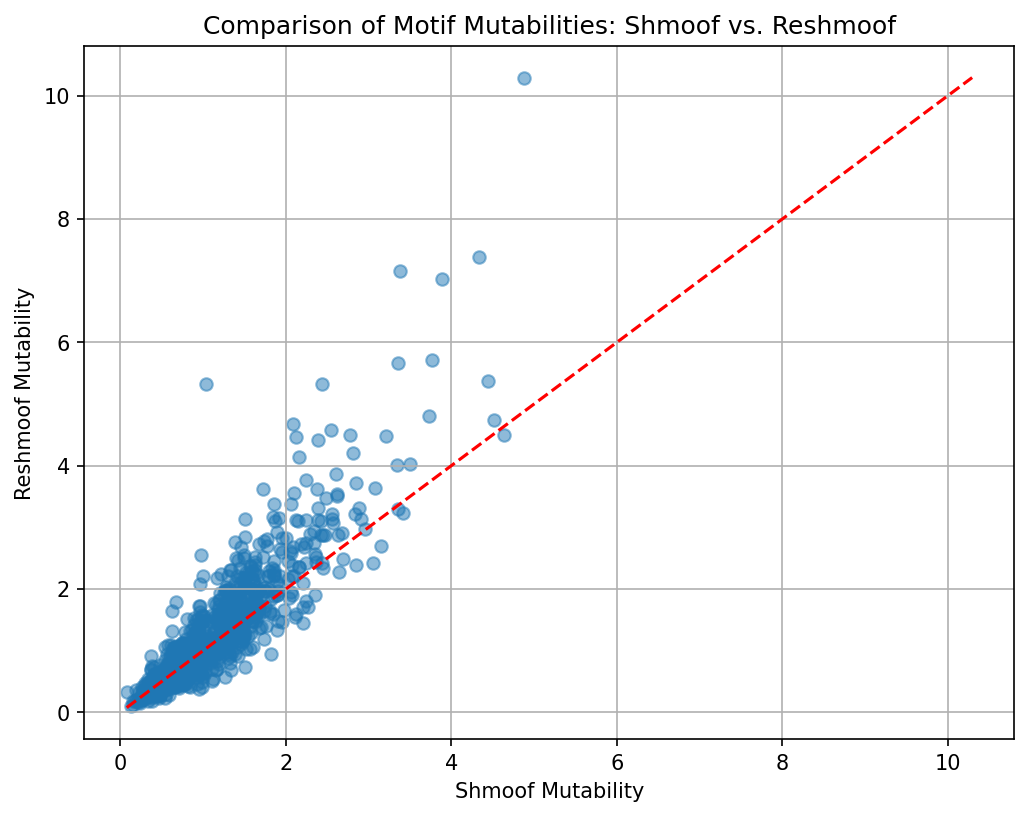

In [49]:
import pandas as pd
import matplotlib.pyplot as plt

# Load motif mutabilities
shmoof_motifs = pd.read_csv('_ignore/original_shmoof/mutabilities_context.tsv', sep='\t')
reshmoof_mutabilities = torch.exp(model.kmer_embedding.weight).squeeze().detach().numpy()
reshmoof_motifs = pd.DataFrame({'Mutability': reshmoof_mutabilities, 'Motif': train_dataset.kmer_to_index.keys()})

# Merge dataframes
merged_motifs = pd.merge(shmoof_motifs, reshmoof_motifs, on='Motif', how='inner', suffixes=('_shmoof', '_reshmoof'))

# Scatter plot
plt.figure(figsize=(8, 6))
plt.scatter(merged_motifs['Mutability_shmoof'], merged_motifs['Mutability_reshmoof'], alpha=0.5)

# Determine bounds for y=x line
min_bound = min(merged_motifs['Mutability_shmoof'].min(), merged_motifs['Mutability_reshmoof'].min())
max_bound = max(merged_motifs['Mutability_shmoof'].max(), merged_motifs['Mutability_reshmoof'].max())

# Add y=x line
plt.plot([min_bound, max_bound], [min_bound, max_bound], 'r--')

plt.xlabel('Shmoof Mutability')
plt.ylabel('Reshmoof Mutability')
plt.title('Comparison of Motif Mutabilities: Shmoof vs. Reshmoof')
plt.grid(True)
plt.show()

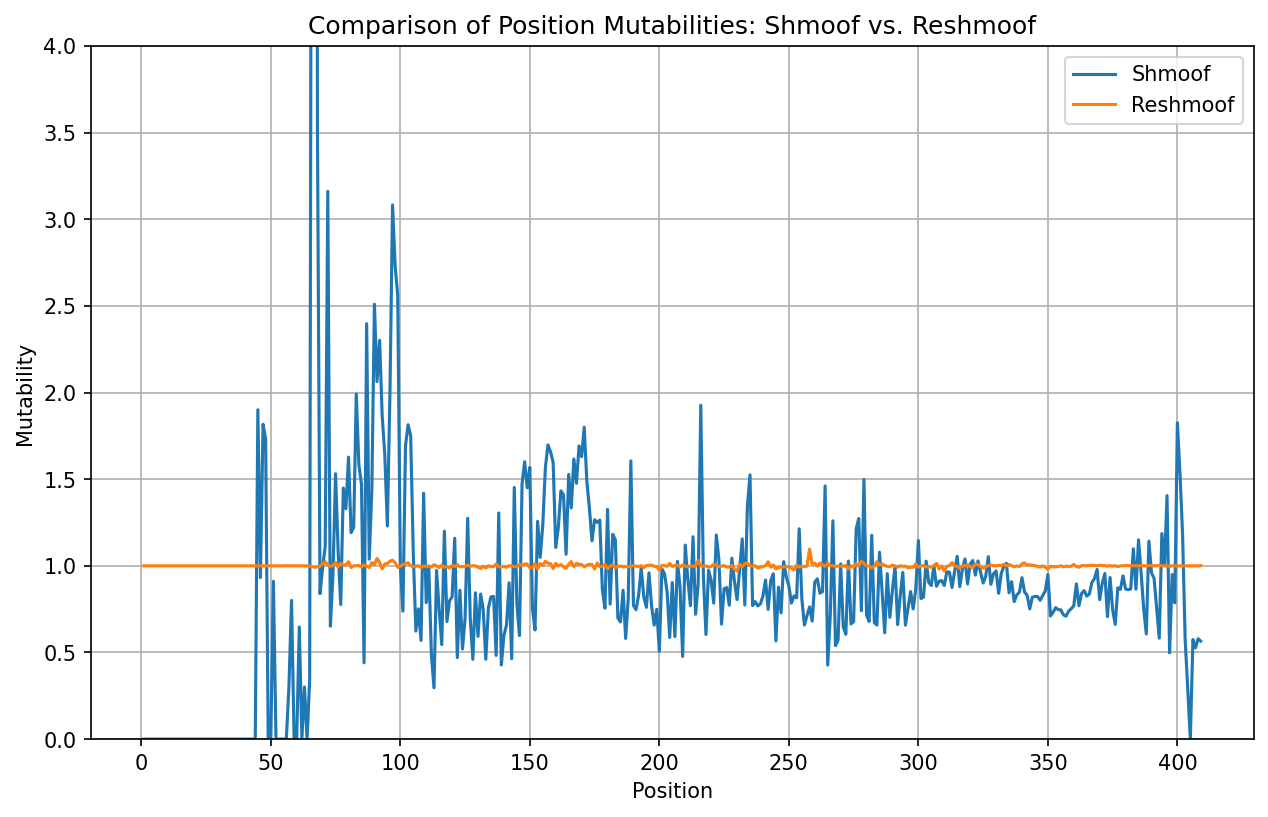

In [50]:
# Load position mutabilities
shmoof_positions = pd.read_csv('_ignore/original_shmoof/mutabilities_position.tsv', sep='\t')
reshmoof_positions = torch.exp(model.log_site_rates.weight).squeeze().detach().numpy()
reshmoof_positions = pd.DataFrame({'Position': np.arange(len(reshmoof_positions)), 'Mutability': reshmoof_positions})

# Merge dataframes
merged_positions = pd.merge(shmoof_positions, reshmoof_positions, on='Position', suffixes=('_shmoof', '_reshmoof'))
merged_positions.sort_values(by='Position', inplace=True)

# Line plot
plt.figure(figsize=(10, 6))
plt.plot(merged_positions['Position'], merged_positions['Mutability_shmoof'], label='Shmoof')
plt.plot(merged_positions['Position'], merged_positions['Mutability_reshmoof'], label='Reshmoof')
plt.xlabel('Position')
plt.ylabel('Mutability')
plt.ylim(0, 4)

plt.title('Comparison of Position Mutabilities: Shmoof vs. Reshmoof')
plt.legend()
plt.grid(True)
plt.show()


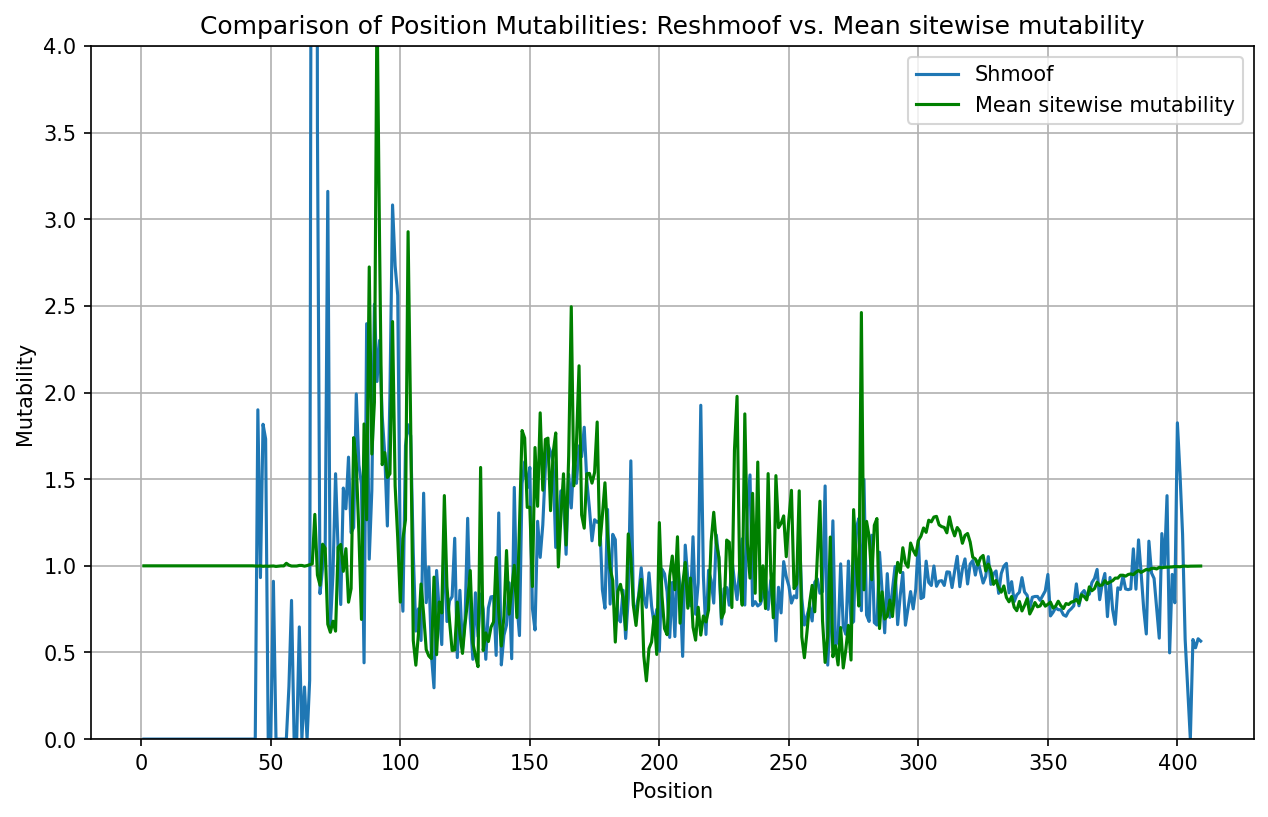

In [44]:
kmer_mutabilities = []

# turn reshmoof_motifs into a dict mapping "Motif" to "Mutability"
reshmoof_motifs_dict = dict(zip(reshmoof_motifs["Motif"], reshmoof_motifs["Mutability"]))

for parent in train_df["parent"]:
    kmer_mutability = np.ones(410)
    padded_parent = "NN" + parent + "NN"
    for i in range(min(410, len(padded_parent) - 5)):
        kmer_mutability[i] = reshmoof_motifs_dict.get(padded_parent[i:i+5], 1.0)
    kmer_mutabilities.append(kmer_mutability)

[kmer_mutability.shape for kmer_mutability in kmer_mutabilities]

mean_sitewise_mutability = np.stack(kmer_mutabilities).mean(axis=0)
mean_sitewise_mutability = pd.DataFrame({'Position': np.arange(len(mean_sitewise_mutability)), 'Mutability': mean_sitewise_mutability})

# Merge dataframes
merged_positions = pd.merge(shmoof_positions, mean_sitewise_mutability, on='Position', suffixes=('_shmoof', '_mean_sitewise'))
merged_positions.sort_values(by='Position', inplace=True)

plt.figure(figsize=(10, 6))
plt.plot(merged_positions['Position'], merged_positions['Mutability_shmoof'], label='Shmoof')
plt.plot(merged_positions['Position'], merged_positions['Mutability_mean_sitewise'], label='Mean sitewise mutability', color='green')
# plt.xlim(75, 200)
plt.ylim(0, 4)
plt.xlabel('Position')
plt.ylabel('Mutability')
plt.title('Comparison of Position Mutabilities: Reshmoof vs. Mean sitewise mutability')
plt.legend()
plt.grid(True)
plt.show()

In [ ]:
regularization_coeffs = [0, 1e-8, 1e-7, 1e-6, 1e-5, 1e-4, 1e-3, 1e-2]
results = []

for coeff in regularization_coeffs:
    print(f"Training with regularization coefficient {coeff}")
    model = SiteRatePenalizedSHMoofModel(train_dataset, penalty_weight=coeff)
    burrito = framework.Burrito(train_dataset, val_dataset, model, batch_size=1024, learning_rate=0.1, l2_regularization_coeff=1e-7)
    loss_history = burrito.train(epochs=100)
    final_training_loss = loss_history['training_losses'].iloc[-1]
    final_validation_loss = loss_history['validation_losses'].iloc[-1]

    results.append({
        'Regularization': coeff,
        'Final_Training_Loss': final_training_loss,
        'Final_Validation_Loss': final_validation_loss
    })

regularization_results_df = pd.DataFrame(results)


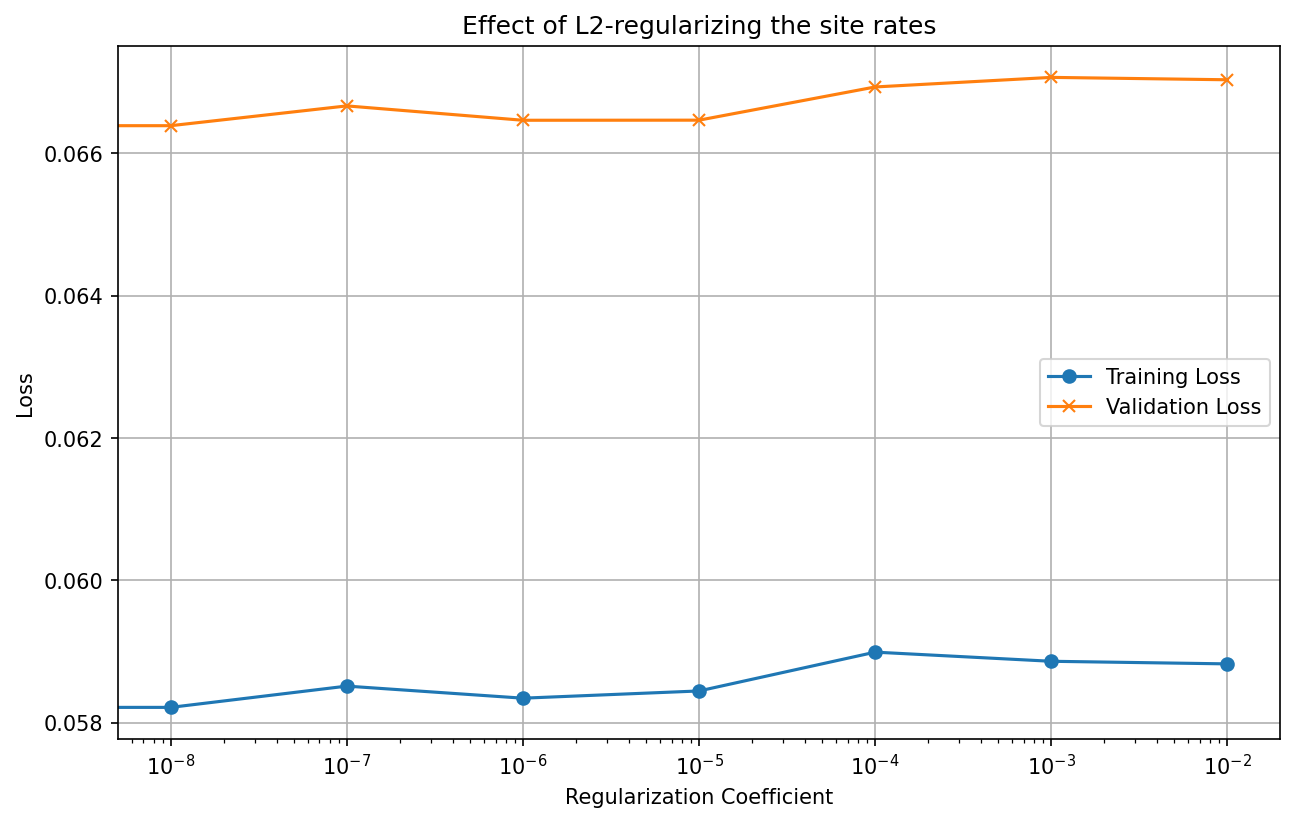

In [40]:
plt.figure(figsize=(10, 6))
plt.plot(regularization_results_df['Regularization'], regularization_results_df['Final_Training_Loss'], label='Training Loss', marker='o')
plt.plot(regularization_results_df['Regularization'], regularization_results_df['Final_Validation_Loss'], label='Validation Loss', marker='x')

plt.xscale('log')
plt.xlabel('Regularization Coefficient')
plt.ylabel('Loss')
plt.title('Effect of L2-regularizing the site rates')
plt.legend()
plt.grid(True)
plt.show()